# Gillespie stochastic simulation algorithme acceleration on GPU
by Titouan Poquillon 03/12/2020

In [1]:
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numba
from numba import cuda
from numba import *
import biocircuits
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer
import numpy as np
import time
import math
# Plotting modules
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
%load_ext line_profiler

Loading BokehJS ...

## Personal CPU-GPU implementation of the GSSA

In [2]:
def GSSA(m, p, t, end, tmax, rand1, rand2):
  """
    Compute one iteration of the GSSA. Run on a GPU kernel
    This is a hard coded methode, only work for the simple protein production reaction:
    DNA--> mRNA -->Protein with hard coded propension: 
    a1 (mRNA production) = 10.0
    a2 (mRNA destruction)= m
    a3 (proteins production)= 10.0*m 
    a4 (proteins destruction)=0.4
    
    Parameters
    ----------
    m : float64
        number of mRNA
    p : float64
        number of proteins
    t : float64
        simulation time
    end : float64
        stat of the simulation, 0.0 if tmax haven't been reached yet, 1.0 else 
    tmax : float64
        time of the next time point
    rand1, float32
        random xoroshiro128p_uniform_float32, between 0 and 1, for reaction selection
    rand1, float32
        random xoroshiro128p_uniform_float32, between 0 and 1, for time of reaction

    Returns
    -------
    m : float64
        number of mRNA
    p : float64
        number of proteins
    t : float64
        simulation time
    end : float64
        stat of the simulation, 0.0 if tmax haven't been reached yet, 1.0 else 
  """
  if end ==1.0 :
    return m, p, t, 1.0

  # compute reactions propensities
  a1 = 10.0
  a2 = m
  a3 = 10.0 * m
  a4 = 0.4 * p
  s = (a1 +a2 +a3 +a4)
  
  # time of reaction
  dt =  - math.log(1-rand2)/s
    
  if t + dt >= tmax :
    return m, p, t, 1.0
  t=t+dt
  
  #Selection of a reaction 
  s2 = s*rand1
  k=a1
  if s2<k:
    return m+1, p, t, 0.0
  k += a2
  if s2< k:
    return m-1, p, t, 0.0
  k += a3
  if s2< k: 
    return m, p+1, t, 0.0
  

  return m, p-1, t, 0.0

GSSA_gpu = cuda.jit(device=True)(GSSA)



In [3]:
@cuda.jit
def GSSA_kernel(image, rand, tmax):
    
    """
    Mannage Kernel atribution and rondom number generation. Link between GSSA_gpu
    and GSSA_master
    This is a hard coded methode, only work for the simple protein production reaction:
    DNA--> mRNA -->Protein with hard coded propension: 
    a1 (mRNA production) = 10.0
    a2 (mRNA destruction)= m
    a3 (proteins production)= 10.0*m 
    a4 (proteins destruction)=0.4
    
    Parameters
    ----------
    image : cuda array 
        n*4 cuda array, where n is the number of simulations run in parralel.
        for each simulation, store m, p, t and "end" the state of the simulation
        (0 if the time point have yet to be reached, 1 else). The gillespi_gpu function run
        on this array
    rand : xoroshiro128p_states
        a random number generator running on GPU
    tmax : time point to come
    """
    
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size
    
    #compute 1000 step for all gillespi simulation 
    for j in range(1000):
        for i in range(start, image.shape[0], stride):
            image[i,:] = GSSA_gpu(image[i, 0],
                                      image[i, 1],
                                      image[i, 2],
                                      image[i, 3],
                                      tmax,
                                      xoroshiro128p_uniform_float32(rand, tx),
                                      xoroshiro128p_uniform_float32(rand, tx))




In [4]:
def GSSA_master(n, time_points):
    """
    Master algorithme above GSSA_kernel and GSSA_gpu, run on CPU
    Launch the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time on GPU processors.
    This is a hard coded methode, only work for the simple protein production reaction:
    DNA--> mRNA -->Protein with hard coded propension: 
    a1 (mRNA production) = 10.0
    a2 (mRNA destruction)= m
    a3 (proteins production)= 10.0*m 
    a4 (proteins destruction)=0.4
    
    Parameters
    ----------
    n : int
        sample size, number of simulation to run in parrallel
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    
    
    """
    
    
    gimage = np.zeros((n, 4), dtype = np.float32) # array to be passed to the GPU
    samples = np.zeros((n,time_points.size,2)) # sample array, recording pop at time points

    threads_per_block = 128 #number of thread per block on the gpu
    blocks_per_grid = 30 #number of block per GPU grids
    
    rng_states = create_xoroshiro128p_states(threads_per_block * blocks_per_grid, seed=int(math.modf(time.time())[0]*10000000))
    for i, t in enumerate(time_points): #for each time point
        gimage[:,3]=0 # (re)initialise all simulation state to 0 (time point not reached) 
        d_image = cuda.to_device(gimage)#send the array to the gpu
        
        while np.count_nonzero(gimage[:,3])< n: # run GSSA_kernel while all simulations have not reach time point
            GSSA_kernel[blocks_per_grid, threads_per_block](d_image, rng_states, t) # run 1000 iteration of GSSA on each simulation 
            d_image.to_host()
        samples[:,i,:] = gimage[:,0:2] #store the population state at time point i for all simulations
    return samples

In [5]:
time_points = np.linspace(0, 50, 101)

In [6]:
t = time.time()
samples = GSSA_master(10000, time_points)
print((time.time()-t))

1.827397108078003


In [7]:
# Set up plots
plots = [bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of mRNAs'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of proteins')]

# Plot trajectories and mean
for i in [0, 1]:
    for x in samples[::100,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

In [8]:
%lprun -T lp_results.txt -f GSSA_master GSSA_master(\
        10000, time_points)


*** Profile printout saved to text file 'lp_results.txt'. 


## Biocircuit CPU implementation of the GSSA

In [9]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0],   # Make mRNA transcript
                          [-1, 0],  # Degrade mRNA
                          [0, 1],   # Make protein
                          [0, -1]], # Degrade protein
                         dtype=np.int)

In [10]:
@numba.njit
def simple_propensity_numba(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein

In [11]:
t = time.time()   
samples = biocircuits.gillespie_ssa(simple_propensity_numba, 
                                    simple_update, 
                                    population_0 = np.array([0, 0], dtype=int), 
                                    time_points = np.linspace(0, 50, 101), 
                                    size=5000, 
                                    args=(10.0,10.0,0.4),
                                    n_threads=1,
                                    progress_bar=False)
print((time.time()-t))

5.188767671585083


In [12]:
samples = samples.reshape((5000,101,2))

In [13]:


# Set up plots
plots = [bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of mRNAs'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of proteins')]

# Plot trajectories and mean
for i in [0, 1]:
    for x in samples[::100,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))



## Benchmark
Comparing both CPU and CPU-GPU methodes on increassing size data

In [14]:

time_points = np.linspace(0, 50, 101)
population_0 = [0,0]
args = (10.0,10.0,0.4)
population_0 = np.array([0, 0], dtype=int)

test = np.zeros((12,2))
time_sample = np.zeros((10,))


for i, size in enumerate([10,20,50,100,200,500,1000,2000,5000,10000,20000, 50000]):
    for j in range(10):
        start = timer()
        GSSA_master(size, time_points)
        time_sample[j] = timer() - start
    test[i,0] = np.median(time_sample)
    

    
    for j in range(10):
        start = timer()
        biocircuits.gillespie_ssa(simple_propensity_numba, 
                                    simple_update, 
                                    population_0, 
                                    time_points, 
                                    size= size, 
                                    args=args,
                                    n_threads=1,
                                    progress_bar=False)
        time_sample[j] = timer() - start
    test[i,1] = np.median(time_sample)

    

<Figure size 60x40 with 0 Axes>

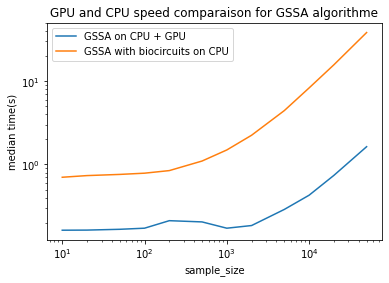

<Figure size 60x40 with 0 Axes>

In [15]:
plt.loglog([10,20,50,100,200,500,1000,2000,5000,10000,20000, 50000],test)
plt.ylabel("median time(s)")
plt.xlabel("sample_size")
plt.title("GPU and CPU speed comparaison for GSSA algorithme")
plt.legend(["GSSA on CPU + GPU ", "GSSA with biocircuits on CPU"])
plt.figure(dpi = 10)

In [16]:
for el,size in zip(test[:,1]/test[:,0], [10,20,50,100,200,500,1000,2000,5000,10000,20000, 50000]):
    print("size: ",size,", GPU speedup on GSSA: *", int(el))

size:  10 , GPU speedup on GSSA: * 4
size:  20 , GPU speedup on GSSA: * 4
size:  50 , GPU speedup on GSSA: * 4
size:  100 , GPU speedup on GSSA: * 4
size:  200 , GPU speedup on GSSA: * 3
size:  500 , GPU speedup on GSSA: * 5
size:  1000 , GPU speedup on GSSA: * 8
size:  2000 , GPU speedup on GSSA: * 12
size:  5000 , GPU speedup on GSSA: * 15
size:  10000 , GPU speedup on GSSA: * 19
size:  20000 , GPU speedup on GSSA: * 21
size:  50000 , GPU speedup on GSSA: * 23
